This notebook is based on the workbook from Pete Cable - https://github.com/petercable/shared_notebooks/blob/master/antelope/Antelope_to_WAV.ipynb

In [57]:
from obspy import read
from obspy.core import UTCDateTime
import wave
from obspy import signal
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift

import numpy as np
import pandas as pd
from time import time

# Packages to perform dimensionality reduction
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold

# Packages for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import offsetbox
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# BE/Bi 103 Utilities from Justin
#import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh
from bokeh import io
bokeh.io.output_notebook()


%matplotlib inline
# data_url = 'https://rawdata.oceanobservatories.org/files/RS01SBPS/PC01A/08-HYDBBA103/2017/08/21/OO-HYVM2--YDH-2017-08-21T11:00:00.000000.mseed'
# localFileName = 'OO-HYVM2--YDH-2017-08-21T11:00:00.000000.mseed'
data_url = 'http://service.iris.edu/irisws/timeseries/1/query?net=OO&sta=AXBA1&cha=HDH&start=2015-04-25T17:45:00&end=2015-04-25T17:55:00&demean=true&output=miniseed&loc=--'
localFileName = 'AXBA1.OO..HDH.2015.115.17.45.00.000-2015.115.17.55.00.000.rm.miniseed'

Loading BokehJS ...

You can download directly from OOI in the program via the url or to speed up development download the file and place it in the same directory as this notebook and then read the local file.

In [58]:
loadFromOOI=True

if loadFromOOI==True :
    stream = read(data_url)
else:
    stream = read(localFileName)  # Read Previoulsy Download local file for speed

# print some stats about this signal
stream

1 Trace(s) in Stream:
OO.AXBA1..HDH | 2015-04-25T17:45:00.000000Z - 2015-04-25T17:55:00.000000Z | 200.0 Hz, 120001 samples

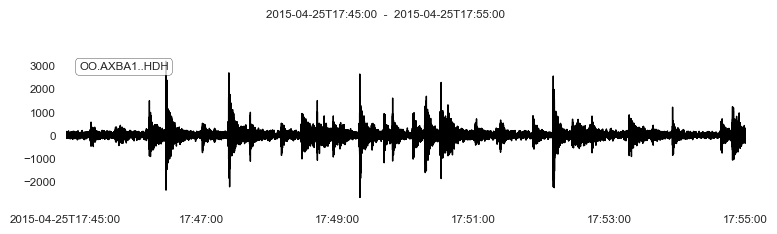

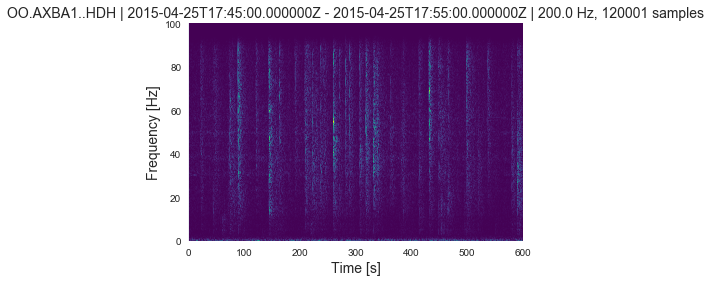

[None]

In [59]:
#Documentation about the obspy library is here https://docs.obspy.org/contents.html
# and list of things you can do with a stream now that its loaded is here
#https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html

#plot the entire 5 minute clip
stream.plot()
stream.spectrogram()

1 Trace(s) in Stream:
OO.AXBA1..HDH | 2015-04-25T17:46:28.000000Z - 2015-04-25T17:46:46.000000Z | 200.0 Hz, 3601 samples


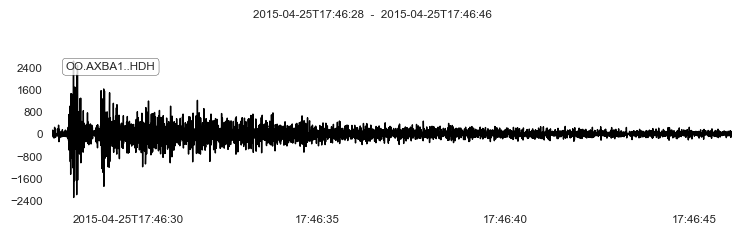

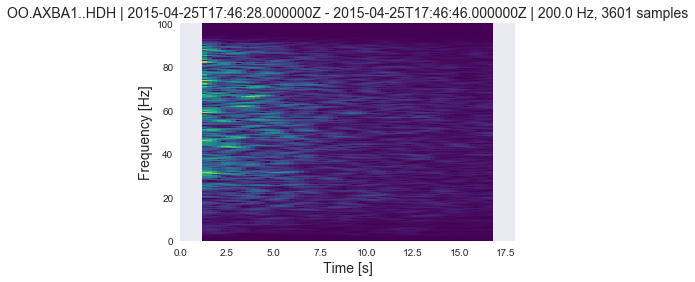

In [68]:
#zoom in and look at just an arbitrary number of seconds

dt = UTCDateTime("2015-04-25T17:46:28")
dur = 18
#dt = UTCDateTime("2017-08-21T11:00:00")
st = stream.slice(dt, dt + dur)
print(st)  
st.plot()

st[0].spectrogram()

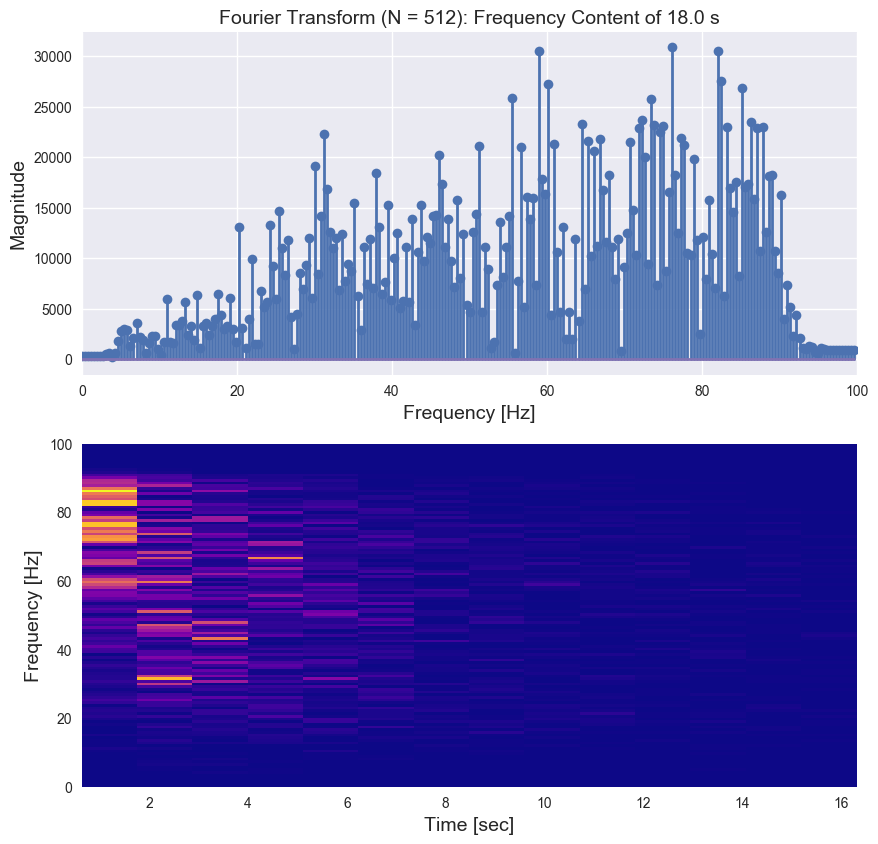

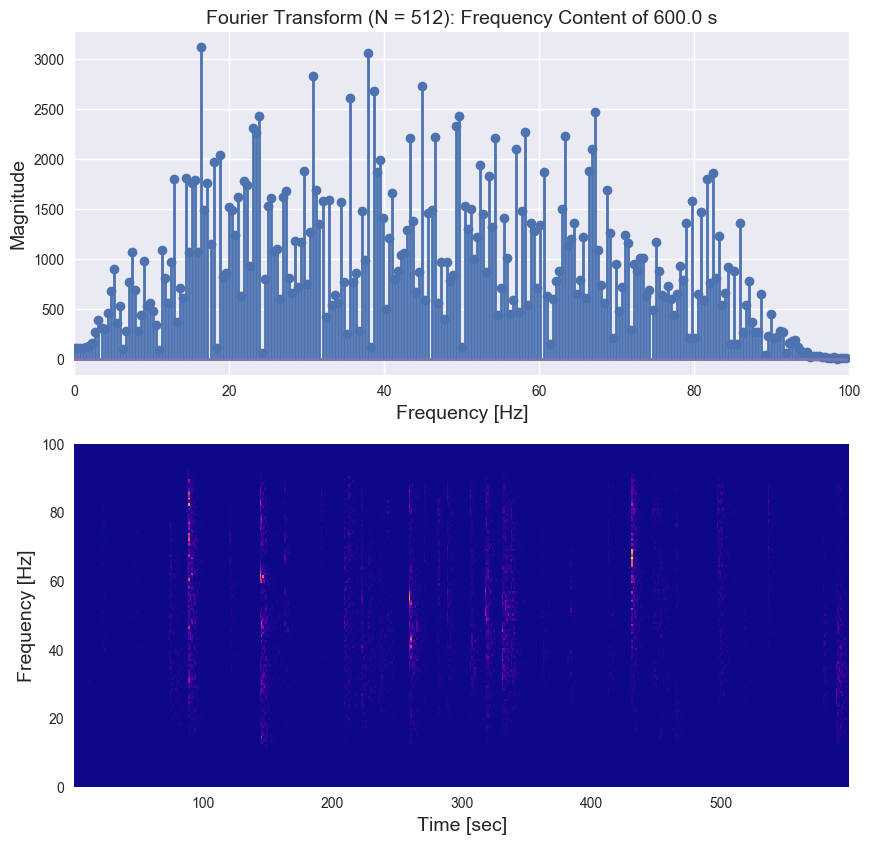

In [88]:
def getSamplingFreq(s):
    string = str(s).split(" ")
    fs = 0;
    for i in range(0, len(string) - 1) :
        char = string[i] 
        count = 1
        if (char == "|"):
            count = count + 1
        if (count == 2):
            fs = string[i + 1]
    return float(fs)

def plotFFT(s):
    y = s[0].copy()
    length = len(s[0])
    N = 512
    Fs = getSamplingFreq(s)
    Y = fftshift(fft(y, N))
    f = fftshift(fftfreq(N, 1/Fs))
    Y = np.abs(np.transpose(Y))
    fig = plt.figure(figsize=(10, 10), dpi=100)
    plt.subplot(2,1,1)
    plt.xlim(0,Fs/2)
    #plt.semilogy(f,Y)
    plt.stem(f,Y)
    plt.title("Fourier Transform (N = " + str(N) + "): Frequency Content of " + str((length-1)/Fs) +  " s")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.subplot(2,1,2)
    f, t, Sxx = signal.spectrogram(np.transpose(y), Fs)
    plt.pcolormesh(t, f, Sxx, cmap='plasma')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

st_filt = st.filter('highpass', freq=2.0)
plotFFT(st_filt)
stream_filt = stream.filter('highpass', freq=2.0)
plotFFT(stream_filt)

In [ ]:
def plot_embedding(embed, title=None, show_classes=True, show_examples=True):
    # Determine range of values of embedded points
    x_min, x_max = np.min(embed, 0), np.max(embed, 0)
    # Scale all points between 0 and 1
    scaled_embed = (embed - x_min) / (x_max - x_min)
    
    # Instantiate figure
    plt.figure()
    ax = plt.subplot(111)
    
    if show_classes:
        # Color each number differently (shows how we expect data to cluster)
        for i in range(scaled_embed.shape[0]):
            plt.plot(scaled_embed[i,0], scaled_embed[i,1], '.',
                     color = plt.cm.Set1(digit_classes[i]/10))
    else:
        plt.plot(scaled_embed[:,0], scaled_embed[:,1], '.k')
    
    if show_examples:
        if hasattr(offsetbox, 'AnnotationBbox'):
            # Only print thumbnail with matplotlib > 1.0;
            # initialize shown_images array
            shown_images = np.array([[1, 1]])

            # Iterate through the number of digits we imported
            for i in range(digits.data.shape[0]):
                dist = np.sum((scaled_embed[i] - shown_images) **2, 1)
                # Don't put thumbnails too close together
                if np.min(dist) < 4e-3:
                    continue
                # Concatenate the  locations of the images to be plotted
                shown_images = np.r_[shown_images, [scaled_embed[i]]]
                # Define the grayscale image of the number
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    scaled_embed[i])
                ax.add_artist(imagebox)
                
    # Remove x and y ticks
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [70]:
# Time the PCA computation
t0 = time()
# Use singular value decomposition to find eigenvalues and eigenvectors
digit_pca = sklearn.decomposition.TruncatedSVD(n_components=2)
# Transform the data
embed_pca = digit_pca.fit_transform(st_filt)
# Store the time
t_pca = time() - t0
# Print time 
print('PCA took %.3fs.' % t_pca)

# Time the tSNE computation
t0 = time()
# Find the optimal low-dimensional representation with t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_tsne = tsne.fit_transform(st_filt)
# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.3fs.' % t_tsne)

plot_embedding(embed_pca, "PCA result", show_classes=False, show_examples=False)
plot_embedding(embed_tsne, "t-SNE result", show_classes=False, show_examples=False)

PCA took 0.008s.


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:192: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


ValueError: Expected n_neighbors > 0. Got 0